# 1. Introduction
## 1.1 Project Aims
The aim of this course work project is to create the best neural network to correctly classify a dataset consisting of 100 different classes of images. The previous coursework was limited to dense and dropout layers while this project will be able to apply the use of more advanced techniques. Convolutional neural networks will be trained and tuned as well as the use of transfer learning will be applied to this problem. 

## 1.2 Dataset Information

The problem for this project is to correctly classify the images from the cifar100 dataset (1). This dataset consists of 100 different classes of images with each class having 500 images for training and 100 left for testing. This is a balanced dataset with a total of 60,000 images that are 32x32 color images. 

[Dataset Link]('https://www.cs.toronto.edu/%7Ekriz/cifar.html')

## 1.3 Evaluation

The choice of an appropriate evaluation metric is dependent on the makeup of the dataset itself. This is a perfectly balanced dataset with each of the 100 classes having 600 occurrences. The use of accuracy or the area under the receiver operating characteristic curve would be appropriate for this particular dataset. Accuracy will be used in this case because it is an easier metric to understand for stakeholders who may be unfamiliar with data science terms and statistics. 

A commonsense baseline accuracy can be determined by the breakdown of the number of classes. In this case there are 100 evenly balanced classes. A random guess of the same class would be able to guess the correct result 1% of the time. A neural network classifier would need to be able to produce an accuracy better than this in order to conclude that the dataset does indeed contain sufficient information. 

This dataset is already split into a test and training dataset. The holdout test set contains 10,000 images, 100 of each class. The training set contains 500 images of each class for a total of 50,000 images. In order to tune a neural network classifier, the training set will be split into a training set and a validation set. A 20/80 split will be used with 20% of the training data being held out for validation. For each class of image, 400 will be used for training, 100 for validation, and a final 100 for the test set. Once the final network has been tuned and trained using the training and validation data, the model will be reinitialized with the validation data included before being tested on the test set. This will produce the final accuracy for our model for which to compare to the common sense baseline. 



1 - Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009

In [ ]:
import keras 
from keras.callbacks import CSVLogger
from tensorflow.keras import models, layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical


# 2. Model Development

Download Dataset

In [2]:
from tensorflow.keras.datasets import cifar100

In [5]:
(train_images_og, train_labels_og), (test_images_og, test_labels_og) = cifar100.load_data()

In [6]:
print('tensor shape')
print('\ttraining images:', train_images_og.shape)
print('\ttraining labels:', train_labels_og.shape)
print('\ttraining images:', train_images_og.dtype)
print('\ttraining labels:', train_labels_og.dtype)
print('\ttest images:', test_images_og.shape)
print('\ttest labels:', test_labels_og.shape)

tensor shape
	training images: (50000, 32, 32, 3)
	training labels: (50000, 1)
	training images: uint8
	training labels: int32
	test images: (10000, 32, 32, 3)
	test labels: (10000, 1)


## 2.1 Data Examination

The dataset consists of images that are 32x32 color images (red, green, blue) resulting in tensor shapes of 32x32x3. There are 50,000 training images and 10,000 test images. The class labels are currently integer encoded,  each label is an integer ranging from 0 to 99. 

### Show Samples

c:\Users\hugho\anaconda3\envs\NN\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


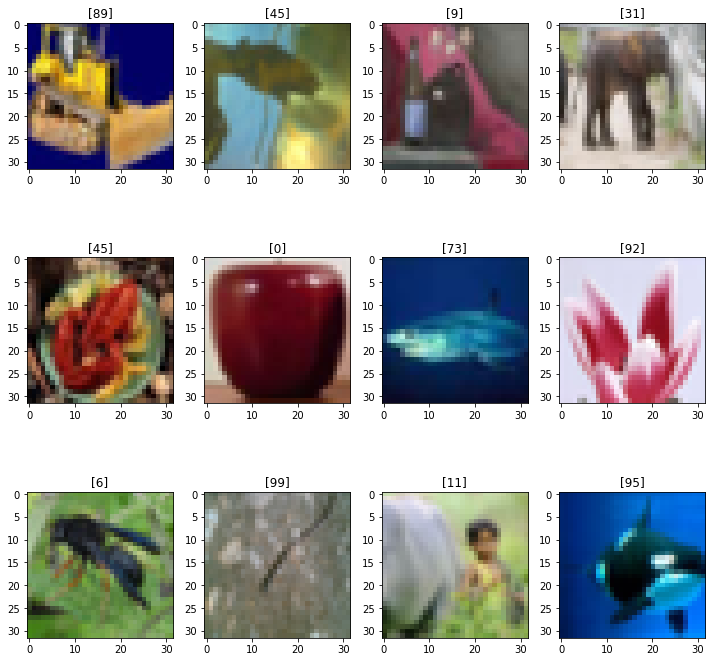

In [7]:
def show_samples(data, labels):
    plt.subplots(figsize=(10, 10))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        k = np.random.randint(0, data.shape[0])
        plt.title(labels[k])
        plt.imshow(data[k])
    plt.tight_layout()
    plt.show()
  
show_samples(train_images_og, train_labels_og)

## 2.2 Preprocess Data
The labels will be transformed using one-hot encoding. This will create a vector of 0's with a 1 in the place of the correct label. This removes the ordered relationship that the classifier may misinterpret if left in. There is no ordered relationship between our classes and one-hot encoding removes the ordered relationship of the integer encoded labels. This is done with the use of ```keras.utils.to_categorical``` function. This will affect the shape of the labels as each label will be a vector of length 100 rather than a single integer. The images will not need to be flattened as done in previous 

#### One-Hot Encode Labels


In [7]:
train_labels = to_categorical(train_labels_og)
test_labels = to_categorical(test_labels_og)

# 3. Baseline Model (Model 0)

The last coursework was able to achieve an accuarcy of 25% on the cifar100 dataset while being restricted to the use of dense and dropout layers. The network consisted of 3 dense layers of 1024 units and a final 100 unit softmax output layer to match the 100 label classifications. The Adama optimizer was used with a learning rate of 1e-4. This previous model will serve as the baseline network. This will setup a good experiment to determine whether the use of convolutional layers and advanced computer vision techniques can improve upon the limited neural network constructed for the previous coursework. 

#### Reshape Image Inputs for CW1 Network Baseline Model
Manually reshaping and rescaling the inputs for the previous coursework model is done to replicate results. When training new models for this coursework the use of the rescaling layer will be used.

In [8]:
train_images = train_images_og.reshape((50000, 32, 32, 3))
test_images = test_images_og.reshape((10000, 32, 32, 3))

In [9]:
train_images_flat = train_images_og.reshape((50000, 32*32*3)).astype('float32') / 255.
test_images_flat = test_images_og.reshape((10000, 32*32*3)).astype('float32') / 255.

In [ ]:
base_model = models.Sequential()   

base_model.add(layers.Dense(1024, activation='relu', input_shape=(32 * 32 * 3, )))

base_model.add(layers.Dense(1024, activation='relu'))
base_model.add(layers.Dense(1024, activation='relu'))

base_model.add(layers.Dense(100, activation='softmax'))

base_model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='categorical_crossentropy',  metrics=['accuracy'])

base_model_history = base_model.fit( train_images_flat,  train_labels,  epochs=12,  validation_split=0.2)

In [13]:
print('Base Model Validation Accuracy: ', round(base_model_history.history['val_accuracy'][-1]*100,5),'%')

Base Model Validation Accuracy:  24.74 %


# 4 Custom Network Development

The following section will examine different combinations of layers, units and hyperparameters to determine the best network possible for this task. A small initial convolutional network will be trained to establish a baseline CNN accuracy. From there, the addition and removal of layers and units, the tuning of hyperparameters, will all be experimented to build a robust model that overfits the data. Then the model network will be further tuned to reduce overfitting of the data through various techniques such as dropout layers, max pooling layers, and data augmentation. 


### 4.1 Develop a Small Base CNN (1)
The first model will exmine the effectiveness of a small base convolution neural network with a small number of filters. A standard window size of 3x3 with as stride of 1 will be used with no maxpooling layers included. 

In [47]:
def build_model_1():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(100, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_1 = build_model_1()

In [ ]:
model_1.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_1 = model_1.fit(
    train_images, 
    train_labels,
    epochs=40,
    verbose=2,
    validation_split=0.2
)

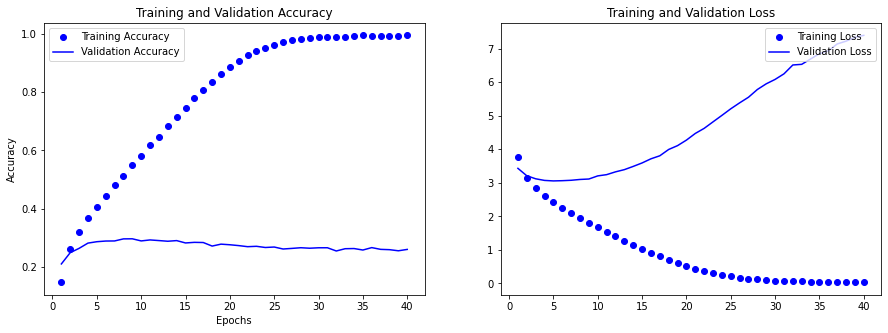

In [54]:
plot_val_loss_acc(history_1)

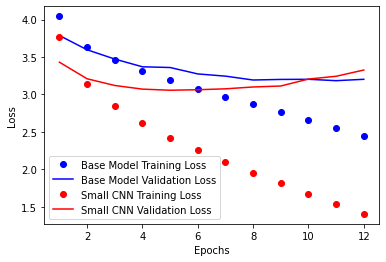

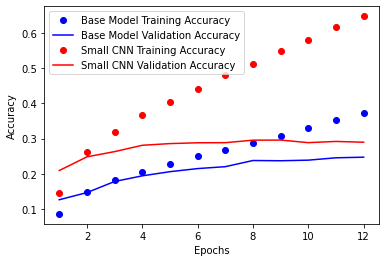

(None, None)

In [55]:
compare_loss_acc(base_model_history, history_1, 'Base Model', 'Small CNN')

**Results of Small CNN Network**
|              | Description   | Max Val Acc |
|--------------|---------------|-------------|
| Model 0      | CW1           | 24.74%      |
| **Model 1** | **CNN Small** | **29.60%**  |

Baseline convnet with 2 convolutional layers achieves a maximum validation accuracy of 29.6%. Already showing improvement over the baseline with no convolutional layers. 

### 4.2 Add Max Pooling Layers to Conv2D layers
Maxpooling layers can help to reduce the number of paratemers a model can train. This can reduce overfitting. It also allows smaller windows in the final layers to be able to look at increasingly large windows of the image to help learn different features. A standard 2x2 window will be used effectively reducing the filter sizes in half. 

In [137]:
def build_model_2():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
    
    x = layers.Flatten()(x)
    outputs = layers.Dense(100, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_2 = build_model_2()

In [ ]:
model_2.compile(optimizer=keras.optimizers.Adam(1e-4),loss = 'categorical_crossentropy',metrics=['accuracy'])

history_2 = model_2.fit(train_images, train_labels, epochs=40, validation_split=0.2, verbose=2)

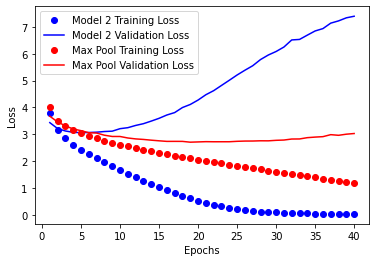

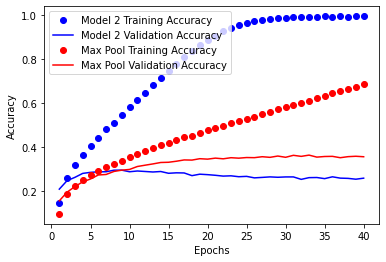

(None, None)

In [140]:
compare_loss_acc(history_1, history_2, 'Model 2', 'Max Pool')

**Results of Max Pooling Layer**
|             | Description     | Max Val Acc | Min Val Loss | Min Val Loss Epoch |
|-------------|-----------------|-------------|--------------|--------------------|
| Model 1     | CNN Small       | 29.60%      |        3.056 |                  4 |
| **Model 2** | **Max Pooling** | **36.43%**  |    **2.711** |             **18** |

The addition of max pooling layers results in the model achievening a higher validation accuracy and lower training loss. The model takes more epochs to begin overfitting. 

### 4.3 Add Dense Layer (3)
The addition of a dense layer after the convolutional layers can be used to aid the network in learning more about the image patterns that have been discovered through the convolutional filters. 

In [132]:
def build_model_3(units=128):
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(units, activation='relu')(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_3 = build_model_3()

In [ ]:
model_3.compile(optimizer=keras.optimizers.Adam(1e-4),loss = 'categorical_crossentropy',metrics=['accuracy'])

history_3 = model_3.fit(train_images, train_labels, epochs=40,verbose=2,validation_split=0.2)

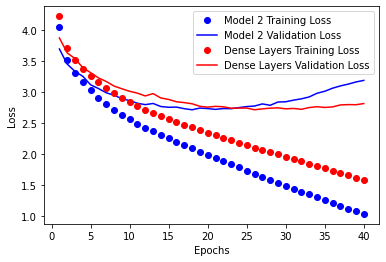

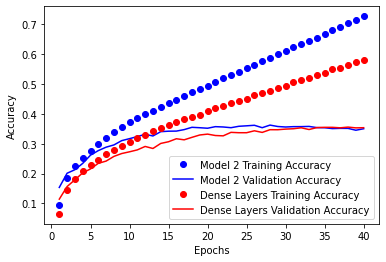

(None, None)

In [60]:
compare_loss_acc(history_2, history_3, 'Model 2', 'Dense Layers')

In [ ]:
model_3a = build_model_3(256)

model_3a.compileoptimizer=(keras.optimizers.Adam(1e-4),loss = 'categorical_crossentropy',metrics=['accuracy'],)
history_3a = model_3a.fit( train_images, train_labels, epochs=40, verbose=2, validation_split=0.2)

In [ ]:
model_3b = build_model_3(64)

model_3b.compile(optimizer=keras.optimizers.Adam(1e-4),loss = 'categorical_crossentropy',metrics=['accuracy'],)
history_3b = model_3b.fit(train_images, train_labels,epochs=100,verbose=2,validation_split=0.2)

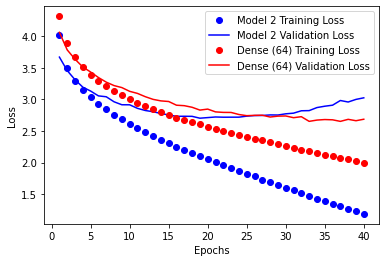

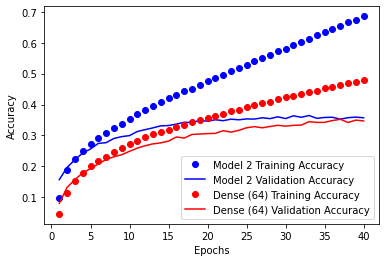

(None, None)

In [165]:
compare_loss_acc(history_2, history_3b, 'Model 2', 'Dense (64)')

The addition of a single dense layer with 128 units at the end of the convolutional layers decreases the validation accuracy to 35.56% from 36.23%. However the addition makes the model slower to overfit. 

Model 3a will test the effect of increasing the size of the dense layer to 256 units and 3b will test the decrease of size to 64 units.


**Results from different sized dense layers at the end of the convolutional layers**
|              | Dense Layer Units | Max Val Acc | Min Val Loss | Min Val Loss Epoch |
|--------------|-------------------|-------------|--------------|--------------------|
| Model 2      | None              | 36.43%      |        2.711 |                 18 |
| Model 3      | 128               |      35.56% |        2.712 |                 25 |
| Model 3a     | 256               |      35.91% |        2.680 |                 17 |
| **Model 3b** | **64**            |  **36.04%** |    **2.652** |             **36** |

Model 3b with a dense layer of 64 units produced the best results of those tested with a validation loss of 2.652 and validation accuracy of 36.04%. However the previous model (2) did have a higher validation accuracy. The addition of a dense layer slowed the training time of the model to start overfitting at 36 epochs instead of 18. The size of the model might still be small at this point for the addition of dense layer. Building up the convolutional base may benefit from a dense layer in future iterations.

### 4.4 Add Conv2D and MaxPooling Layer (4)
Test whether the addition of another convolutional and max pooling layer is needed to learn more patterns. 

In [145]:
def build_model_4():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.Flatten()(x)
    
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_4 = build_model_4()

In [ ]:
model_4.compile(optimizer=keras.optimizers.Adam(1e-4), loss = 'categorical_crossentropy', metrics=['accuracy'])

history_4 = model_4.fit(train_images, train_labels, epochs=40, validation_split=0.2)

Model 4: 4 Conv2D Layers
Max Validation Accuracy:  34.39 %	 Num Epoch:  37
Min Validation Loss:  2.6977 		 Num Epoch:  38


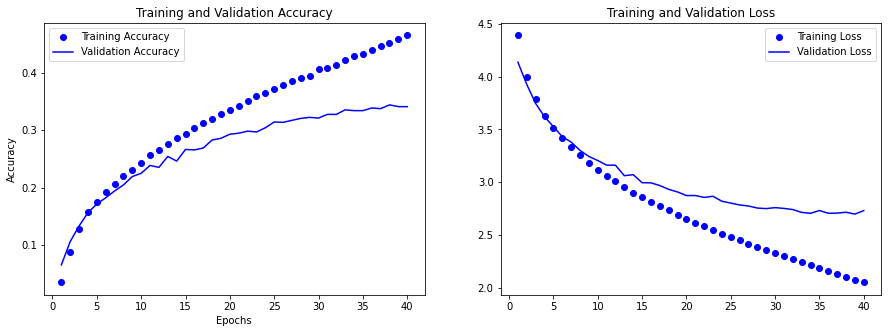

In [147]:
get_max_acc_min_loss_epoch(history_4, 'Model 4: 4 Conv2D Layers')
plot_val_loss_acc(history_4)

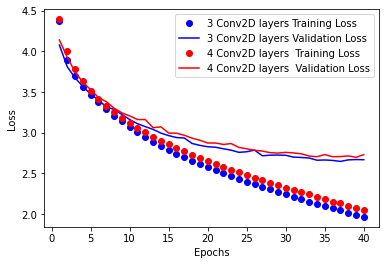

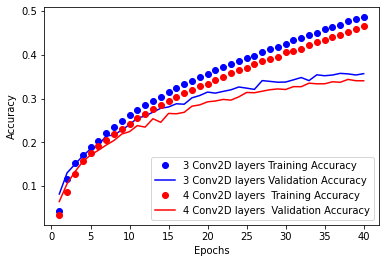

(None, None)

In [151]:
compare_loss_acc(history_3b, history_4, '3 Conv2D layers', '4 Conv2D layers ')


**Results of Additional Conv2D and MaxPooling Layers**
|              | # Conv2D and MP Layers | Max Val Acc | Min Val Loss | Min Val Loss Epoch |
|--------------|------------------------|-------------|--------------|--------------------|
| **Model 3b** | **3**                  |  **36.04%** |    **2.652** |             **36** |
| Model 4      | 4                      | 34.39%      | 2.698        | 38                 |

The results show that there is not much of a change in results when adding further layers. Adding these layers did slow the training speed of the model, with overfitting occuring closer to 40 epochs instead of 25. The simpler model with fewer layers will be chosen.  While they are close, choosing the simpler model is the best choice here. 


### 4.5 Kernal size 4 (5)

Increasing the size of the windows used in the convolutional layer has the effect of the layers learning larger patterns. 

In [149]:
def build_model_5():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=16, kernel_size=4, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=32, kernel_size=4, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=64, kernel_size=4, activation="relu", padding='same')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_5 = build_model_5()

In [ ]:
model_5.compile(optimizer=keras.optimizers.Adam(1e-4), loss = 'categorical_crossentropy', metrics=['accuracy'])
history_5 = model_5.fit(train_images, train_labels,epochs=40, validation_split=0.2)

Model 5: Conv2D 4x4 Kernal
Max Validation Accuracy:  34.69 %	 Num Epoch:  39
Min Validation Loss:  2.72545 		 Num Epoch:  33


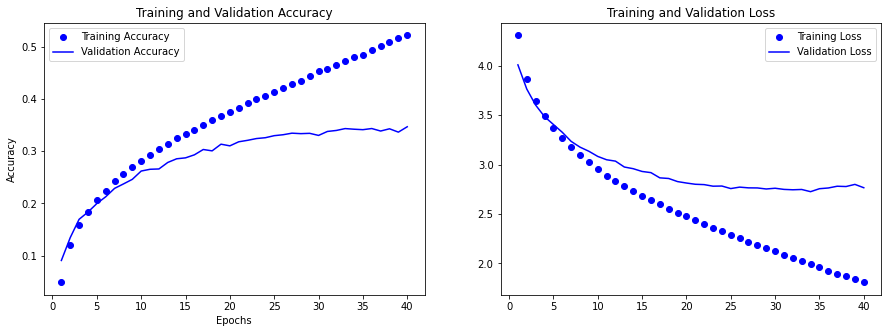

In [152]:
get_max_acc_min_loss_epoch(history_5, 'Model 5: Conv2D 4x4 Kernal')
plot_val_loss_acc(history_5)


**Results of Change in Kernal Window Size**  
|         | Kernal Size | Max Val Acc | Min Val Loss |
|---------|-------------|-------------|--------------|
| **Model 3b**| **3x3**         | **36.04%**      | **2.653**        |
| Model 5 | 4x4         | 34.69%      | 2.725        |

The increase in window (kernal) size results in a model that begins overfitting sooner and the maximum validation accuarcy slightly decreases as well so the 3x3 kernal size is deemed a better fit.

### 4.6 Higher and Lower Learning Rates (6,7)

Experiment to determine the optimal learning rate. A learning rate that is too high could miss a proper fit during the gradient descent algorithm. A learning rate that is too low could be too slow to learn and result in a stalled out learning process.

In [ ]:
model_6 = build_model_3(64)

model_6.compile(optimizer=keras.optimizers.Adam(1e-3), loss = 'categorical_crossentropy', metrics=['accuracy'])
history_6 = model_6.fit(train_images, train_labels,epochs=40,validation_split=0.2)

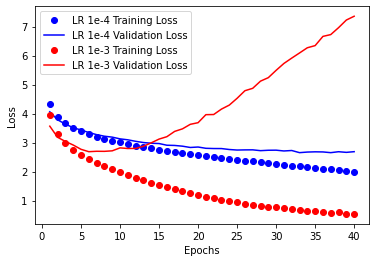

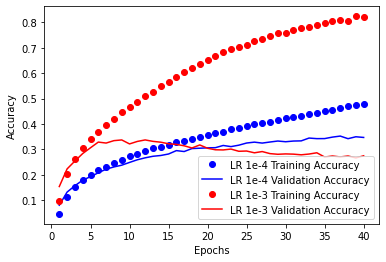

(None, None)

In [168]:
compare_loss_acc(history_3b, history_6, 'LR 1e-4', 'LR 1e-3')

In [ ]:
model_7 = build_model_3(64)
model_7.compile(optimizer=keras.optimizers.Adam(5e-5),loss = 'categorical_crossentropy',metrics=['accuracy'])
history_7 = model_7.fit(train_images, train_labels,epochs=100,validation_split=0.2)

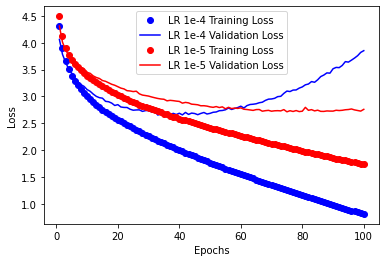

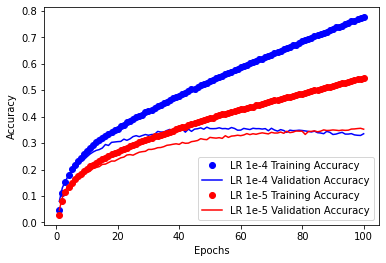

(None, None)

In [173]:
compare_loss_acc(history_3b, history_7, 'LR 1e-4', 'LR 1e-5')

**Results of Learning Rate Changes**
|          | Learning Rate | Max Val Acc | Min Val Loss | Min Loss Epoch (overfitting) |
|----------|---------------|-------------|--------------|------------------------------|
| **Model 3b**| **3x3**         | **36.04%**      | **2.653**        | **36**   |
| Model 6  | 1e-3          | 33.69%      | 2.686        | 5                            |
| Model 7  | 5e-5          | 35.61%      | 2.713        | 74                           |

The higher learning rate of 1e-3 appears to reach its peak accuracy too soon. This is the risk of increasing the learning rate too high, it may skips over the optimum fit and begins overfitting without finding the optimum minumum. The lower learning rate trained much more slowly as expected. It took around 75 epochs to begin overfitting but the minumum loss was still greater than that of the learning rate 1e-4. The original learning rate is still the best candidate.


### 4.7 Increase Starting Filter Sizes (8)

Increasing the amount of filters used in each convolutional layer could allow the network to learn more patterns in the data and increase overall accuracy. However, too many and this could lead to overfitting. The increase in filter sizes may also require increase in the units in the dense layer because there is more information outputed from the previous layers.

In [174]:
def build_model_8():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_8 = build_model_8()


In [ ]:
model_8.compile(optimizer=keras.optimizers.Adam(1e-4), loss = 'categorical_crossentropy', metrics=['accuracy'])
history_8 = model_8.fit(train_images, train_labels, epochs=50, validation_split=0.2)

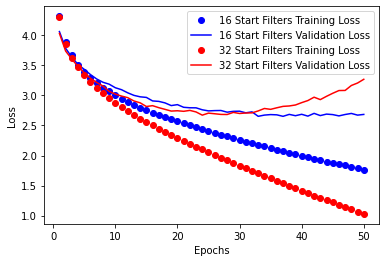

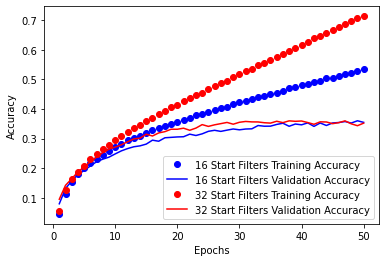

(None, None)

In [179]:
compare_loss_acc(history_3b, history_8, '16 Start Filters','32 Start Filters')

Increasing the starting convolutional layer filters paramater to 32 units increases the validation accuracy and reduces validation loss. Model begins overfitting at 18 epochs when validation loss is minimized. 

In [ ]:
model_8b.compile(optimizer=keras.optimizers.Adam(1e-4), loss = 'categorical_crossentropy',metrics=['accuracy'], )
history_8b = model_8b.fit( train_images,  train_labels, epochs=50, validation_split=0.2)

Model 8b: Layer 1 128 Filters
Max Validation Accuracy:  34.93 %	 Num Epoch:  14
Min Validation Loss:  2.76014 		 Num Epoch:  12
Model 8: Layer 1 64 Filters
Max Validation Accuracy:  36.01 %	 Num Epoch:  37
Min Validation Loss:  2.67217 		 Num Epoch:  23


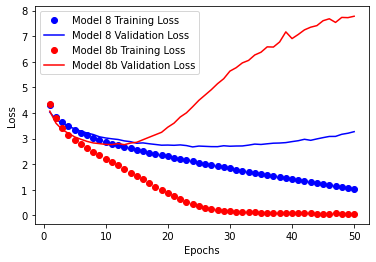

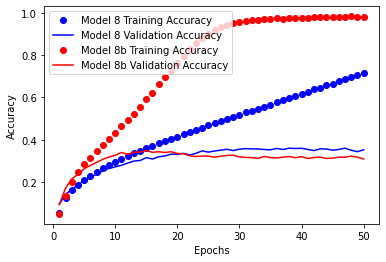

(None, None)

In [ ]:
model_8c.compile( optimizer=keras.optimizers.Adam(1e-4), loss = 'categorical_crossentropy', metrics=['accuracy'])
history_8c = model_8c.fit(train_images,train_labels,epochs=50,validation_split=0.2)

In [ ]:
model_8d.compile(optimizer=keras.optimizers.Adam(1e-4),loss = 'categorical_crossentropy',metrics=['accuracy'],)
history_8d = model_8d.fit( train_images, train_labels, epochs=50, validation_split=0.2)

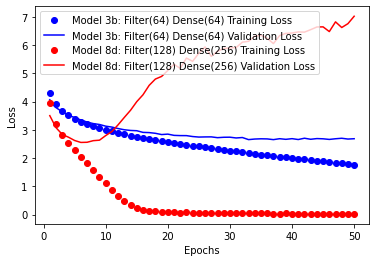

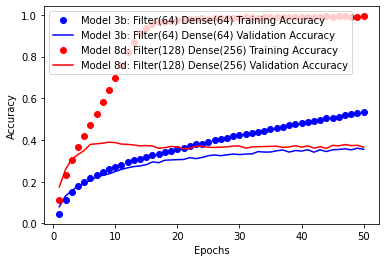

(None, None)

In [190]:
compare_loss_acc(history_3b, history_8d, 'Model 3b: Filter(64) Dense(64)', 'Model 8d: Filter(128) Dense(256)')

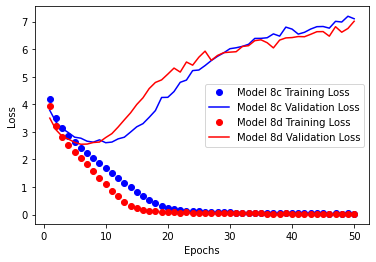

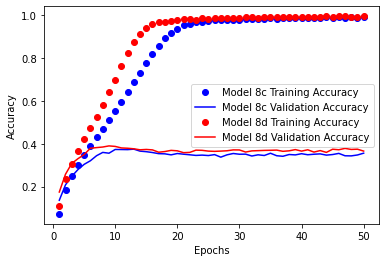

(None, None)

In [188]:
compare_loss_acc(history_8c, history_8d, 'Model 8c', 'Model 8d')

In [ ]:
model_8e.compile( optimizer=keras.optimizers.Adam(1e-4), loss = 'categorical_crossentropy', metrics=['accuracy'],)
history_8e = model_8e.fit( train_images,  train_labels, epochs=25, validation_split=0.2)

**Results of Change in Starting Filter Size and Dense Layer Units**
|              | Starting Filter Size | Dense Layer Units | Max Val Acc | Min Val Loss | Min Loss Epoch (overfitting) |
|--------------|----------------------|-------------------|-------------|--------------|------------------------------|
| Model 3b     | 32                   | 64                | 36.04%      | 2.653        | 36                           |
| Model 8a     | 64                   | 64                | 36.01%      | 2.672        | 23                           |
| Model 8b     | 128                  | 64                | 34.93%      | 2.760        | 12                           |
| Model 8c     | 64                   | 128               | 37.46%      | 2.608        | 9                            |
| Model 8d     | 128                  | 256               | 38.97%      | 2.553        | 5                            |
| **Model 8e** | **256**              | **512**           | **40.84%**  | **2.522**    | **4**                        |

The increase in filter sizes did not improve the model initially. A further increase in starting size from 64 (model 8) to 128 (model 8a) actually reduced the models predictive accuracy significantly. It was then tested whether increasing the size of the dense layer may help improve because the increase in filter size would incrcease the amount of information coming into the dense layer, and it could possibly need more capacity to learn from the inputs produced. The results of this test in model 8c and 8d do indeed result in lower validation loss and higher accuracy. It is worth testing whether or not increasing the size of the filters and dense layers further results in even better results. Further increasing the starting filter size to 256 and dense layer units to 512 did again increase the validation accuracy and reduce the validation loss. The bigger the size of filters and units, the quicker the model achievens overfitting. 

### 4.8 Remove Padding (9)


In [197]:
def build_model_9():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu")(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_9 = build_model_9()

In [ ]:
model_9.compile(optimizer=keras.optimizers.Adam(1e-4), loss = 'categorical_crossentropy', metrics=['accuracy'], )

history_9 = model_9.fit( train_images, train_labels, epochs=20, validation_split=0.2 )

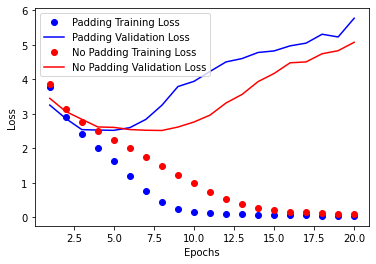

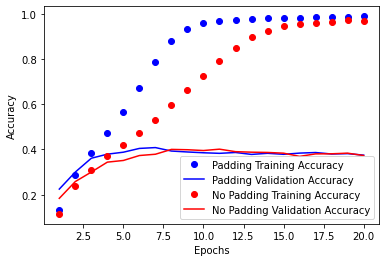

(None, None)

In [200]:
compare_loss_acc(history_8e, history_9, 'Padding','No Padding')

**Results of Removing Padding**
|          | Padding | Max Val Acc | Min Val Loss | Min Loss Epoch (overfitting) |
|----------|---------|-------------|--------------|------------------------------|
| **Model 8e** | **Yes**     | **40.84%**      | **2.522**        | **4**                            |
| Model 9  | No      | 40.14%      | 2.517        | 7                            |

Taking away the use of padding actually reduces overfitting and slightly improves accuarcy and loss.

### 4.9 Four Conv2D Layer Max Pooling Blocks with 128 Starting Filters (10)
Test the addition of another block of Conv2D and Maxpooling layers. Padding must be used however or else final filters get reduced too negative values. 

In [203]:
def build_model_10():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
       
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu", padding='same')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Model_10_4_Conv2d_layers')
    return model

model_10 = build_model_10()

In [204]:
model_10.compile(optimizer=keras.optimizers.Adam(1e-4), loss = 'categorical_crossentropy', metrics=['accuracy'], )

history_10 = model_10.fit( train_images, train_labels, epochs=25, validation_split=0.2)

Model 10: 4 Conv2D
Max Validation Accuracy:  39.76 %	 Num Epoch:  6
Min Validation Loss:  2.4469 		 Num Epoch:  5
Model 9: 3 Conv2D
Max Validation Accuracy:  40.14 %	 Num Epoch:  10
Min Validation Loss:  2.51796 		 Num Epoch:  7


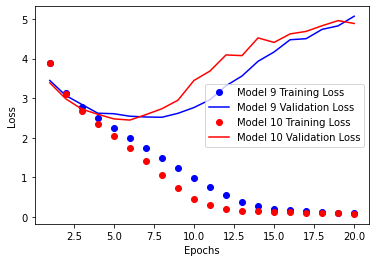

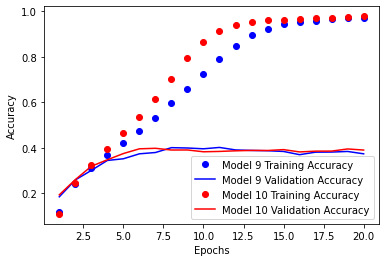

(None, None)

In [206]:
get_max_acc_min_loss_epoch(history_10, 'Model 10: 4 Conv2D')
get_max_acc_min_loss_epoch(history_9, 'Model 9: 3 Conv2D')
compare_loss_acc(history_9, history_10, 'Model 9','Model 10')

**Results of Additional Conv2D + MaxPool Block**
|          | Conv2D & Max Pool Blocks | Padding | Max Val Acc | Min Val Loss | Min Loss Epoch (overfitting) |
|----------|--------------------------|---------|-------------|--------------|------------------------------|
| **Model 9**  | **3**                        | **No**      | **40.14%**      | **2.517**        | **7**                            |
| Model 10 | 4                        | Yes     | 39.76%      | 2.4469       | 5                            |

Additional layer reduced loss and model trained fairly quickly to reach overfitting.

### 4.10 Increase Dense Layers w. Dropout (11)
This will test a variety of dense layer units and dropout rates after the current convolutional network. Currently the model is overfitting rather quickly. Dropout layers should help to reduce the overfitting and make the model more resiliant to new data in validation. Several combinations of dropout rates, dense layer units, and number of dense layer dropout blocks are trialed and results reported.

In [224]:
def build_model_11(dropout=0.5, num_layers=1, units=512):
    inputs = keras.Input(shape=(32, 32, 3))

    x = layers.Rescaling(1./255)(inputs) 
    
    
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu", padding='same')(x)
    
    x = layers.Flatten()(x)
    for i in list(range(1, num_layers+1)):
      x = layers.Dense(units, activation='relu')(x)
      x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Model_Augmentation_W_Dropout')
    return model

model_11a = build_model_11(0.5, 1)
model_11b = build_model_11(0.5, 2)
model_11c = build_model_11(0.3, 1)
model_11d = build_model_11(0.3, 2)
model_11e = build_model_11(0.5, 2, 256)
model_11f = build_model_11(0.2, 1, 1024)
model_11g = build_model_11(0.5, 3, 512)
model_11s = [
    model_11a,
    model_11b,
    model_11c,
    model_11d,
    model_11e,
    model_11f,
]

In [ ]:
def trial_model_11(model_11s):
  model_11_results = []
  for model in model_11s:
      model.compile(optimizer=keras.optimizers.Adam(1e-4), loss = 'categorical_crossentropy', metrics=['accuracy'])
      
      history = model.fit(train_images, train_labels, epochs=25, validation_split=0.2 )

      model_11_results.append(history)

  for i, hist in enumerate(model_11_results):
    get_max_acc_min_loss_epoch(hist, f'Model 11.{i}')

trial_model_11(model_11s)

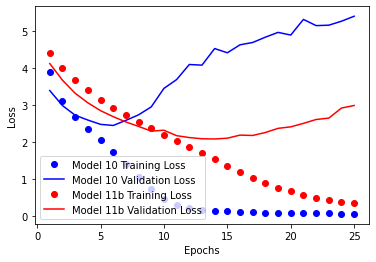

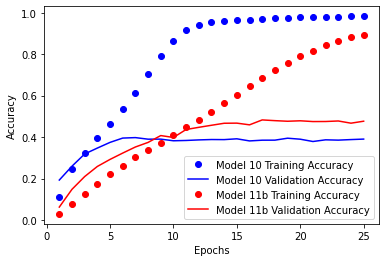

(None, None)

In [221]:
compare_loss_acc(history_10, model_11_results[1], 'Model 10', 'Model 11b')

**Results of Increase Dense Layers w. Dropout Tests**
|               | # Blocks | Dense Units | Dropout Rate | Max Val Acc | Min Val Loss | Min Loss Epoch (overfitting) |
|---------------|----------|-------------|--------------|-------------|--------------|------------------------------|
| Model 11a     | 1        | 512         | 0.5          | 45.23%      | 2.311        | 9                            |
| **Model 11b** | **2**    | **512**     | **0.5**      | **48.29%**  | **2.082**    | **13**                       |
| Model 11c     | 1        | 512         | 0.3          | 42.94%      | 2.307        | 7                            |
| Model 11d     | 2        | 512         | 0.3          | 46.13%      | 2.197        | 10                           |
| Model 11e     | 2        | 256         | 0.5          | 46.98%      | 2.146        | 18                           |
| Model 11f     | 1        | 1024        | 0.2          | 41.88%      | 2.367        | 4                            |
| Model 11g     | 3        | 512         | 0.5          | 43.84%      | 2.349        | 13                           |

Adding dropout layers and more dense layers resulted in a large improvement. Two blocks of a 512 unit dense layers and dropout layer with a rate of 0.5 resulted in a validation accuarcy of 48.29% and validation loss of 2.082. Model 11g test whether a 3rd block of dense and dropout layers continues to improve the model but validation loss incrceased by quite a bit in this configuration so model 11b is the best choice of these experiments.


### 4.12 Batch Normalization (12)

Test the use of batch normalization layers to reduce overfitting. This is acomplished by normalizing the data outputted by intermediate layers in the network. 


In [233]:
def build_model_12():
    inputs = keras.Input(shape=(32, 32, 3))
    
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=128, kernel_size=3, use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=512, kernel_size=3, use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters=1024, kernel_size=3, use_bias=False, activation='relu', padding='same')(x)
    
        
    x = layers.Flatten()(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)


    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Model_13_Batch_Normalization')
    return model

model_12 = build_model_12()

In [ ]:
model_12.compile(optimizer=keras.optimizers.Adam(1e-4), loss = 'categorical_crossentropy', metrics=['accuracy'], )

history_12 = model_12.fit(train_images, train_labels, epochs=30, validation_split=0.2)

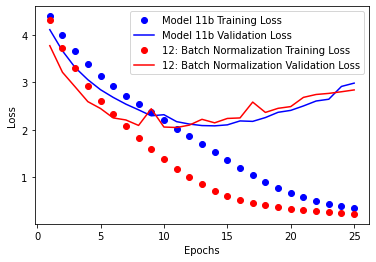

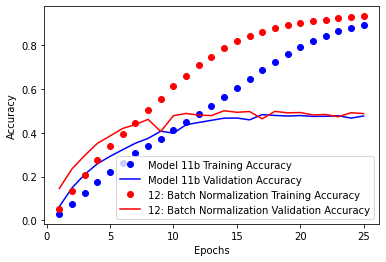

Model 12: Batch Normalization
Max Validation Accuracy:  50.080000000000005 %	 Num Epoch:  13
Min Validation Loss:  2.04718 		 Num Epoch:  10


In [236]:
compare_loss_acc(model_11_results[1], history_12, 'Model 11b', '12: Batch Normalization')
get_max_acc_min_loss_epoch(history_12, 'Model 12: Batch Normalization')


**Results of Batch Normaziation**
|           | Batch Normalization | Max Val Acc | Min Val Loss | Min Loss Epoch (overfitting) |
|-----------|---------------------|-------------|--------------|------------------------------|
| Model 11b | No                | 48.29%      | 2.082        | 13                           |
| **Model 12**  | **Yes**                 | **50.08%**      | **2.047**        | **10**                           |

The use of batch normalization did further increase validation accuracy and reduce loss. Overfitting began at 10 epochs.

### 4.13 Residuals (14)

The use of residual connections aims to reduce the propogation of noise through successive layers by adding the input of a layer or block of layers back to its output. 

In [7]:
def build_model_14():
    inputs = keras.Input(shape=(32, 32, 3))
    
    x = layers.Rescaling(1./255)(inputs) 
    
    def residual_block(x, filters, pooling=False): 
      residual = x
      x = layers.BatchNormalization()(x)
      x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
      x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
      if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual) 
      elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual) 
      x = layers.add([x, residual])
      return x
    
    x = residual_block(x, 128, pooling=True)
    x = residual_block(x, 256, pooling=True)
    x = residual_block(x, 512, pooling=True)

    x = layers.Conv2D(filters=1024, kernel_size=3, use_bias=False, activation='relu', padding='same')(x)

    x = layers.Flatten()(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Model_14_Residuals')
    return model

model_14 = build_model_14()


In [ ]:
model_14.compile( optimizer=keras.optimizers.Adam(1e-4), loss = 'categorical_crossentropy', metrics=['accuracy'],)

history_14 = model_14.fit( train_images,  train_labels, epochs=40, validation_split=0.2)

In [15]:
get_max_acc_min_loss_epoch(history_14, 'Model 13: Residuals')



Model 13: Residuals
Max Validation Accuracy:  51.83 %	 Num Epoch:  10
Min Validation Loss:  1.94449 		 Num Epoch:  7


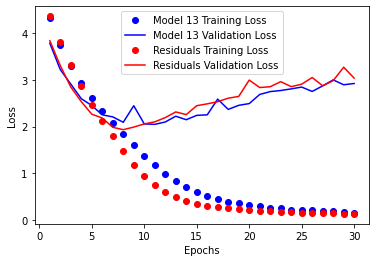

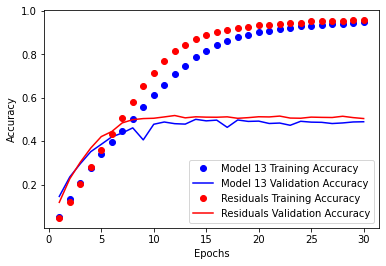

(None, None)

In [246]:
compare_loss_acc(history_12, history_14, 'Model 13', 'Residuals')


**Results of Adding Residuals**
|              | Residuals | Max Val Acc | Min Val Loss | Min Loss Epoch (overfitting) |
|--------------|-----------|-------------|--------------|------------------------------|
| Model 12     | No        | 50.08%      | 2.047        | 10                           |
| **Model 14** | **Yes**   | **51.83%**  | **1.944**    | **7**                        |

The addition of resudiuals made a significant improvement to the model. The use of residuals helps to reduce the noise that gets propogated through a network through successive layers. As the model begins to grow with more layers, the more the noise of each layer can affect the final output. Adding the residuals back into the model helps to keep the base information in tact and successively adds to the predictive accuracy of this network. This model achieved an accuarcy of 51.8% and began overfitting at 7 epochs. 

### 4.14 Depthwise Separable Convolution Layers (15)

In [248]:
def build_model_15():
    inputs = keras.Input(shape=(32, 32, 3))
    
    x = layers.Rescaling(1./255)(inputs) 
    # need a conv2d layer to begin to handle color
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)

    def residual_block(x, filters, pooling=False): 
      residual = x
      x = layers.BatchNormalization()(x)
      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)

      x = layers.BatchNormalization()(x)
      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)

      if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual) 
      elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual) 
      x = layers.add([x, residual])
      return x
    
    x = residual_block(x, 128, pooling=True)
    x = residual_block(x, 256, pooling=True)
    x = residual_block(x, 512, pooling=True)

    x = layers.Conv2D(filters=1024, kernel_size=3, use_bias=False, activation='relu', padding='same')(x)

    x = layers.Flatten()(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)


    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Model_16_Residuals')
    
    return model


model_15 = build_model_15()


In [ ]:
model_15.compile( optimizer=keras.optimizers.Adam(1e-4), loss = 'categorical_crossentropy', metrics=['accuracy'])

history_15 = model_15.fit( train_images,  train_labels, epochs=30, validation_split=0.2)

Model 15: Seperable Conv2d
Max Validation Accuracy:  48.75 %	 Num Epoch:  13
Min Validation Loss:  2.05709 		 Num Epoch:  10


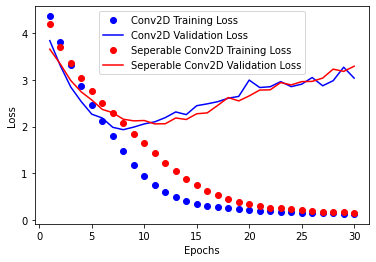

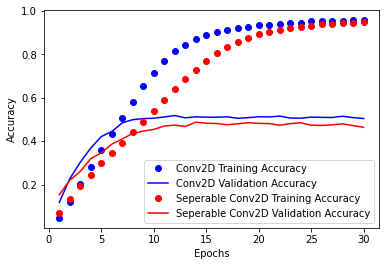

(None, None)

In [251]:
get_max_acc_min_loss_epoch(history_15, 'Model 15: Seperable Conv2d')
compare_loss_acc(history_14, history_15, 'Conv2D', 'Seperable Conv2D')

**Results of Seperable CNN Layers Test**
|              | Type of CNN     | Max Val Acc | Min Val Loss | Min Loss Epoch (overfitting) |
|--------------|-----------------|-------------|--------------|------------------------------|
| **Model 14** | Conv2D          | **51.83%**  | **1.944**    | **7**                        |
| Model 15     | SeparableConv2D | 48.75%      | 2.057        | 10                           |

The use of seperable convolution layers did not improve the model.  


## 4.15 Data Augmentation (16)

The use of data augmentation can have the effect of reducing overfitting by creating more noise in the training data and making the model more resiliant to new data. Images are altered using transformations such as zooming, rotating, translation and others. It has the effect of exposing the network to new variants of the data that would otherwise would not be visible.  

In [ ]:
data_augmentation = keras.Sequential([
      layers.RandomFlip('horizontal_and_vertical', input_shape=(32,32,3)),
      layers.RandomRotation(0.2),
      layers.RandomZoom(0.2)
])

def build_model_16():
    inputs = keras.Input(shape=(32, 32, 3))
    
    x = data_augmentation(inputs)
    
    x = layers.Rescaling(1./255)(x) 
    
    def residual_block(x, filters, pooling=False): 
      residual = x
      x = layers.BatchNormalization()(x)
      x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
      x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
      if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual) 
      elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual) 
      x = layers.add([x, residual])
      return x
    
    x = residual_block(x, 128, pooling=True)
    x = residual_block(x, 256, pooling=True)
    x = residual_block(x, 512, pooling=True)

    x = layers.Conv2D(filters=1024, kernel_size=3, use_bias=False, activation='relu', padding='same')(x)

    x = layers.Flatten()(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Model_14_Residuals')
    return model

model_16 = build_model_16()

In [ ]:
model_16.compile(optimizer=keras.optimizers.Adam(1e-4),loss = 'categorical_crossentropy',metrics=['accuracy'],)

history_16 = model_16.fit( train_images,  train_labels, epochs=5, validation_split=0.2 )

**Training Validation Accuracy and Loss For Data Augmentation Network**

![Alt text](data%20aug%20results.png)

**Results of Data Augmentation**
|              | Data Augmentation | Max Val Acc | Min Val Loss | Min Loss Epoch (overfitting) |
|--------------|-------------------|-------------|--------------|------------------------------|
| Model 14     | No                | 51.83%      | 1.944        | 7                            |
| **Model 16** | **Yes**           | **51.84%**  | **1.9263**   | **54**                       |

Data Augmentation resulted in a model much slower to train taking close to 60 epochs vs only 7. The top validation accuracy was similar to Model 14 but validation loss did decrease slightly. Overall these models were very similar in results but data augmentation made for a much slower time to train. The computational cost of training is the deciding factor to continue using model 14 as the top choice.


# 5 Pretrained model

The use of a model that has been previously trained can produce promising results. The vgg16 neural network model has been trained on much more data than this dataset and we can use that base to build off of for our dataset. By harnesing the patterns already learned in vgg16, there is a potential to be able to apply that knowledge to this dataset for an even more accurate model.

### Base Pretrained VGG16 (17)
Take the pretrained model and freeze the convolutional base so that previously learned patterns in this network are kept intact during training on this dataset. First model will add two blocks of dense and dropout layers to the pretrained base which will be trained on the new dataset. Second model will unfreeze the last 3 layers of the pretrained network to fine tune the network to the new cifar100 dataset. 

In [18]:
base_model_vgg16 = keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape = (32,32,3),
    include_top=False
)


def build_ft_model_1():
    
    base_model_vgg16.trainable=False

    inputs = keras.Input(shape=(32, 32, 3))
   
    x = keras.applications.vgg16.preprocess_input(inputs)

    x = base_model_vgg16(x, training=False)

    x = layers.Flatten()(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(100, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='FT_Model')

    return model


ft_model_1 = build_ft_model_1()

Train model once with complete base frozen.

In [ ]:
ft_model_1.compile(optimizer=keras.optimizers.Adam(1e-4),loss = 'categorical_crossentropy',metrics=['accuracy'],)

history_ft_1 = ft_model_1.fit(train_images, train_labels,epochs=50,validation_split=0.2)

Unfreeze the final 3 layers and then retrain the model with a lower learning rate in order to limit any major modifacations to the pretrained network layers that have been unfrozen.

In [ ]:
base_model_vgg16.trainable = True
for layer in base_model_vgg16.layers[:-4]:
 layer.trainable = False

ft_model_1.compile( optimizer=keras.optimizers.Adam(1e-5), loss = 'categorical_crossentropy', metrics=['accuracy'],)

history_ft_2 = ft_model_1.fit( train_images,  train_labels, epochs=50, validation_split=0.2)


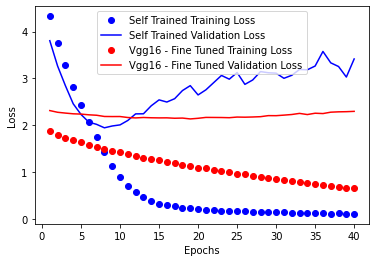

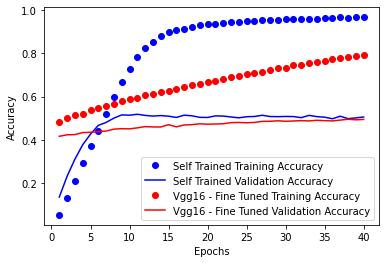

(None, None)

In [25]:
compare_loss_acc(history_14, history_ft_2, 'Self Trained', 'Vgg16 - Fine Tuned')

**Results of Pre-Trained Model**
|              | Description      | Max Val Acc | Min Val Loss | Min Loss Epoch (overfitting) |
|--------------|------------------|-------------|--------------|------------------------------|
| **Model 14** | **Self Trained** | **51.83%**  | **1.944**    | **7**                        |
| Model 17     | VGG16 Fine Tuned | 50.12%      | 2.134        | 18                           |

Unfreezing the final 3 layers increased the accuracy from 41% to 51% but this is still lower than the self trained model.

## Table Summary of Results

In [6]:
pd.read_csv('./cw2results4.csv', index_col='Model Number').sort_values(['Min Val Loss'])

,Model Description,Max Val Acc,Min Val Loss,Min Val Loss Epoch
Model Number,,,,
16,Data Augmentation,51.83%,1.9420,25.0
14,Residuals,51.83%,1.9440,7.0
12,Batch Normalization,50.00%,2.0470,10.0
15,Depthwise Seperable Conv,48.00%,2.0570,11.0
11,Additional Dense and Dropout Layers,48.29%,2.0820,13.0
17,VGG16,50.12%,2.1340,18.0
10,Additional Conv2d Max Pool,39.76%,2.4470,5.0
9,No Padding,40.14%,2.5180,7.0
8e,Filter start 256 - Dense 512,40.84%,2.5220,4.0


# 6 Final Model Evaluation

The custom model 13 proved to be the best trained model with a validation accuarcy of 51.83% and a clear dip in validation loss. Fine tuning the vgg16 model was able to produce a validation accuarcy score of 50.12%. In order to test our final model, it will be retrained using all the training data, this includes the validation data previously held out. Then the model will be evaluated on the holdout test data that has not previousyl been used. 

### Final Self-Trained Model (16)

The model will be trained for 29 epochs because this is when it began to show overfitting. 

Final Model
Max Validation Accuracy:  51.83 %	 Num Epoch:  10
Min Validation Loss:  1.94449 		 Num Epoch:  7


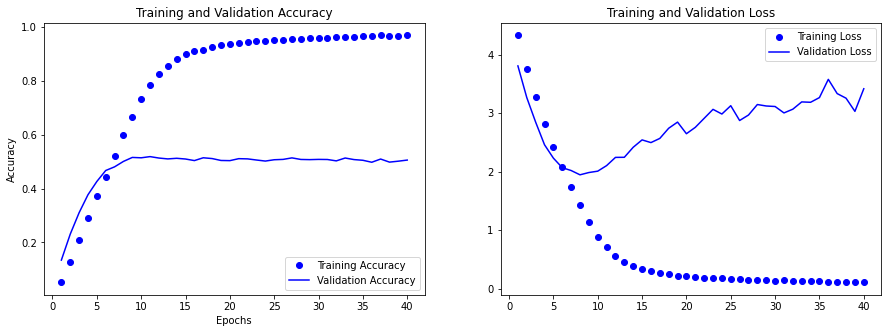

In [26]:
get_max_acc_min_loss_epoch(history_14, 'Final Model')
plot_val_loss_acc(history_14)

In [29]:
final_model_self_trained = build_model_15()
final_model_self_trained.summary()


Model: "Model_14_Residuals"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_2 (Rescaling)        (None, 32, 32, 3)    0           ['input_10[0][0]']               
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 32, 32, 3)   12          ['rescaling_2[0][0]']            
 rmalization)                                                                                     
                                                                                                  
 conv2d_20 (Conv2D)             (None, 32, 32, 128)  3584        ['batch_normaliz

In [30]:
final_model_self_trained.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

final_model_self_trained.fit(
    train_images, 
    train_labels,
    epochs=7,
    verbose=2,
)

Epoch 1/7
1563/1563 - 43s - loss: 4.2799 - accuracy: 0.0570 - 43s/epoch - 28ms/step
Epoch 2/7
1563/1563 - 43s - loss: 3.6256 - accuracy: 0.1484 - 43s/epoch - 27ms/step
Epoch 3/7
1563/1563 - 43s - loss: 3.0400 - accuracy: 0.2494 - 43s/epoch - 27ms/step
Epoch 4/7
1563/1563 - 43s - loss: 2.5584 - accuracy: 0.3438 - 43s/epoch - 27ms/step
Epoch 5/7
1563/1563 - 43s - loss: 2.1579 - accuracy: 0.4293 - 43s/epoch - 28ms/step
Epoch 6/7
1563/1563 - 43s - loss: 1.8168 - accuracy: 0.5033 - 43s/epoch - 28ms/step
Epoch 7/7
1563/1563 - 43s - loss: 1.4914 - accuracy: 0.5799 - 43s/epoch - 28ms/step


#### Evaluate Model On Test Data

In [32]:
final_results_self_trained = final_model_self_trained.evaluate(test_images, test_labels)
print('Final Pre-trained Model Accuracy: ', round(final_results_self_trained[1]*100,2),'%')
print('Final Pre-trained Model Loss: ', final_results_self_trained[0])

313/313 [==============================] - 3s 10ms/step - loss: 1.8470 - accuracy: 0.5179
Final Pre-trained Model Accuracy:  51.79 %
Final Pre-trained Model Loss:  1.8469609022140503


# 7 Conclusion

The final custom model was able to achieve an accuarcy of 51.79% on the hold out test data. This is a very good improvement over the previous coursework model which was only able to achieve an accuarcy of 24.5%. The use of more advanced computer vision neural network techniques has been able to double the accuracy. The final model architecture consisted of 3 blocks of convolutional layers, max pooling layers, and residuals. The output from the convolutional blocks was fed into a GlobalAveragePooling2D layer. This was then fed into 2 dense (512 units) and dropout (0.5) layer combinations before being output into the final dense softmax layer. 

# Apendix Code

#### Chart Plotting Code



In [13]:
def plot_train_val_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def plot_train_val_acc(history):
    plt.clf()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
        
    epochs = range(1, len(acc) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
        
    plt.plot(epochs, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation Accuracy')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

def plot_val_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)
    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    # plt.plot(epochs_range, acc, label='Training Accuracy')
    # plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    
 
    plt.plot(epochs_range, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, solid_blue_line, label = 'Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, blue_dots, label='Training Loss')
    plt.plot(epochs_range, val_loss, solid_blue_line, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
  
def compare_loss(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['loss']), len(hist2.history['loss']))
    loss = hist1.history['loss'][:min_epochs]
    val_loss = hist1.history['val_loss'][:min_epochs]
    loss_drop = hist2.history['loss'][:min_epochs]
    val_loss_drop = hist2.history['val_loss'][:min_epochs]

    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, loss, blue_dots, label = f'{title1} Training Loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = f'{title1} Validation Loss')
    plt.plot(epochs, loss_drop, red_dots, label = f'{title2} Training Loss')
    plt.plot(epochs, val_loss_drop, solid_red_line, label = f'{title2} Validation Loss')
    # plt.title('Loss With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def compare_acc(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['accuracy']), len(hist2.history['accuracy']))
    acc = hist1.history['accuracy'][:min_epochs]
    val_acc = hist1.history['val_accuracy'][:min_epochs]
    acc_drop = hist2.history['accuracy'][:min_epochs]
    val_acc_drop = hist2.history['val_accuracy'][:min_epochs]
    
    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, acc, blue_dots, label = f'{title1} Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = f'{title1} Validation Accuracy')
    plt.plot(epochs, acc_drop, red_dots, label = f'{title2} Training Accuracy')
    plt.plot(epochs, val_acc_drop, solid_red_line, label = f'{title2} Validation Accuracy')
    # plt.title('Accuracy With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
  
def compare_loss_acc(hist1, hist2, title1, title2):
  return compare_loss(hist1, hist2, title1, title2), compare_acc(hist1, hist2, title1, title2)


#### Get Maximum Validation Accuracy and Minimum Validation Loss
Take the history from the models trained and return the maximum validation accuracy and the epoch at which it occurred as well as the minimum validation loss and the epoch at which it occurred.


In [14]:
def get_max_val_acc_epoch(history):
  val_acc = history.history['val_accuracy']
  max_val_acc = round(max(val_acc),5)*100
  max_epoch = np.argmax(val_acc)
  print('Max Validation Accuracy: ', max_val_acc, '%\t Num Epoch: ', max_epoch)
  return 
  
def get_min_val_loss_epoch(history):
  val_loss = history.history['val_loss']
  min_val_loss = round(min(val_loss),5)
  min_epoch = np.argmin(val_loss)
  print('Min Validation Loss: ', min_val_loss, '\t\t Num Epoch: ', min_epoch)
  return 
  
def get_max_acc_min_loss_epoch(history, model_name):
  print(model_name)
  get_max_val_acc_epoch(history)
  get_min_val_loss_epoch(history)
